In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Đọc file Excel và load sheet "Dulieu0205"
df=pd.read_excel('Processed_THONGKESVISHOCTUCHON.xlsx',sheet_name='Dulieu0205')

In [2]:
import numpy as np
import pandas as pd

# Giả sử df là DataFrame của bạn
# Step 1: Xác định số môn học tối đa mà một sinh viên có
max_courses_per_student = df.groupby('IDSinhVien').size().max()

# Step 2: Tạo ma trận vuông - thêm 0 cho các sinh viên có ít môn học hơn sinh viên có nhiều môn học nhất
def create_padded_matrix(df, max_courses):
    students_matrices = []
    student_ids = df['IDSinhVien'].unique()

    for student_id in student_ids:
        # Lấy dữ liệu của sinh viên này
        student_data = df[df['IDSinhVien'] == student_id]
        
        # Loại bỏ các cột không phải số để tạo ma trận
        numeric_data = student_data.select_dtypes(include=[np.number])
        
        # Tạo ma trận cho sinh viên này, thêm 0 nếu cần
        padded_data = np.zeros((max_courses, numeric_data.shape[1]))
        padded_data[:numeric_data.shape[0], :] = numeric_data.values
        
        students_matrices.append(padded_data)
    
    return np.array(students_matrices)

# Step 3: Tạo ma trận cho tất cả sinh viên
padded_matrix = create_padded_matrix(df, max_courses_per_student)

# Kiểm tra kích thước của ma trận vuông đã tạo
print("Kích thước của ma trận:", padded_matrix.shape)


Kích thước của ma trận: (591, 14, 7)


In [3]:
padded_matrix[0]


array([[1.00000e+00, 2.59330e+04, 1.67725e+06, 3.19700e+03, 8.00000e+00,
        0.00000e+00, 3.00000e+00],
       [1.00000e+00, 2.59330e+04, 1.67725e+06, 3.20300e+03, 7.60000e+00,
        0.00000e+00, 4.00000e+00],
       [1.00000e+00, 2.59330e+04, 1.67725e+06, 3.39500e+03, 8.90000e+00,
        0.00000e+00, 2.00000e+00],
       [1.00000e+00, 2.59330e+04, 1.67725e+06, 1.07600e+03, 7.90000e+00,
        1.00000e+00, 5.00000e+00],
       [1.00000e+00, 2.59330e+04, 1.67725e+06, 9.01000e+02, 9.50000e+00,
        1.00000e+00, 4.00000e+00],
       [1.00000e+00, 2.59330e+04, 1.67725e+06, 3.89300e+03, 9.30000e+00,
        0.00000e+00, 6.00000e+00],
       [1.00000e+00, 2.59330e+04, 1.67725e+06, 4.03200e+03, 8.40000e+00,
        0.00000e+00, 6.00000e+00],
       [1.00000e+00, 2.59330e+04, 1.67725e+06, 1.29500e+03, 7.60000e+00,
        0.00000e+00, 7.00000e+00],
       [1.00000e+00, 2.59330e+04, 1.67725e+06, 1.36600e+03, 8.30000e+00,
        1.00000e+00, 7.00000e+00],
       [1.00000e+00, 2.59330

In [4]:
# Chuẩn bị dữ liệu thành ma trận One-Hot Encoding như trong hình
def create_one_hot_encoding_matrix(df):
    # Xác định các cột cần giữ lại và các cột cần one-hot encode
    columns_to_keep = ['IDSinhVien', 'MaMonHoc', 'DiemTongKet', 'Thuộc KCNTT', 'HK']
    df_filtered = df[columns_to_keep]
    
    # One-hot encode cột 'HK'
    df_one_hot = pd.get_dummies(df_filtered, columns=['HK'], prefix='HK')
    
    return df_one_hot

# Tạo ma trận One-Hot Encoding
df_one_hot_encoded = create_one_hot_encoding_matrix(df)

# Hiển thị một phần của dữ liệu để kiểm tra
df_one_hot_encoded.head()


,IDSinhVien,MaMonHoc,DiemTongKet,Thuộc KCNTT,HK_2,HK_3,HK_4,HK_5,HK_6,HK_7
0,1677250,3197,8.0,0,False,True,False,False,False,False
1,1677250,3203,7.6,0,False,False,True,False,False,False
2,1677250,3395,8.9,0,True,False,False,False,False,False
3,1677250,1076,7.9,1,False,False,False,True,False,False
4,1677250,901,9.5,1,False,False,True,False,False,False


In [5]:
# Chuyển đổi các giá trị True/False thành 1/0
df_one_hot_encoded = df_one_hot_encoded.astype(int)

# Hiển thị lại dữ liệu sau khi chuyển đổi
df_one_hot_encoded.head()


,IDSinhVien,MaMonHoc,DiemTongKet,Thuộc KCNTT,HK_2,HK_3,HK_4,HK_5,HK_6,HK_7
0,1677250,3197,8,0,0,1,0,0,0,0
1,1677250,3203,7,0,0,0,1,0,0,0
2,1677250,3395,8,0,1,0,0,0,0,0
3,1677250,1076,7,1,0,0,0,1,0,0
4,1677250,901,9,1,0,0,1,0,0,0


In [21]:
# Tách dữ liệu thành tập huấn luyện và kiểm tra
X = df_one_hot_encoded.drop(columns=['DiemTongKet'])
y = df_one_hot_encoded['DiemTongKet']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình RandomForest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Huấn luyện mô hình SVR
svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

# Huấn luyện mô hình LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Tính toán Mean Squared Error cho mỗi mô hình
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_svr = mean_squared_error(y_test, y_pred_svr)
mse_lr = mean_squared_error(y_test, y_pred_lr)


# Tính toán độ chính xác với ngưỡng 10% (Accuracy Ratio)
def accuracy_within_threshold(y_true, y_pred, threshold=0.1):
    return np.mean(np.abs((y_true - y_pred) / y_true) < threshold) * 100

accuracy_rf = accuracy_within_threshold(y_test, y_pred_rf)
accuracy_svr = accuracy_within_threshold(y_test, y_pred_svr)
accuracy_lr = accuracy_within_threshold(y_test, y_pred_lr)

# Hiển thị kết quả
print(f'Mean Squared Error for RandomForest: {mse_rf}')
print(f'Accuracy within 10% for RandomForest: {accuracy_rf}%')

print(f'Mean Squared Error for LinearRegression: {mse_lr}')
print(f'Accuracy within 10% for LinearRegression: {accuracy_lr}%')


Mean Squared Error for RandomForest: 3.5723895392278955
Accuracy within 10% for RandomForest: 43.46201743462018%
Mean Squared Error for LinearRegression: 3.0890033092453293
Accuracy within 10% for LinearRegression: 39.22789539227895%


In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Chuẩn bị dữ liệu như trước đó
X = df_one_hot_encoded.drop(columns=['DiemTongKet'])
y = df_one_hot_encoded['DiemTongKet']

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu (quan trọng đối với mô hình DL)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Chuyển đổi nhãn mục tiêu thành dạng numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)


In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Xây dựng mô hình Sequential
model = models.Sequential()

# Thêm các lớp vào mô hình
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))  # Lớp đầu vào
model.add(layers.Dense(32, activation='relu'))  # Lớp ẩn thứ nhất
model.add(layers.Dense(16, activation='relu'))  # Lớp ẩn thứ hai
model.add(layers.Dense(1))  # Lớp đầu ra

# Compile mô hình
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Hiển thị kiến trúc của mô hình
model.summary()


c:\Users\ICT\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Đánh giá mô hình trên tập kiểm tra
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')


Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8117 - mae: 1.1162 - val_loss: 2.4040 - val_mae: 1.0684
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4512 - mae: 1.0564 - val_loss: 2.4564 - val_mae: 1.1058
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5966 - mae: 1.0805 - val_loss: 2.4187 - val_mae: 1.0894
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5539 - mae: 1.0720 - val_loss: 2.4401 - val_mae: 1.0885
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6093 - mae: 1.0942 - val_loss: 2.3984 - val_mae: 1.0478
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7542 - mae: 1.0997 - val_loss: 2.5794 - val_mae: 1.1455
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6776 - mae: 1.1054 - val_loss: 2.4887 - val_mae: 1.1203
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4997 - mae: 1.0775 - val_loss: 2.3977 - val_mae: 1.0822
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.765

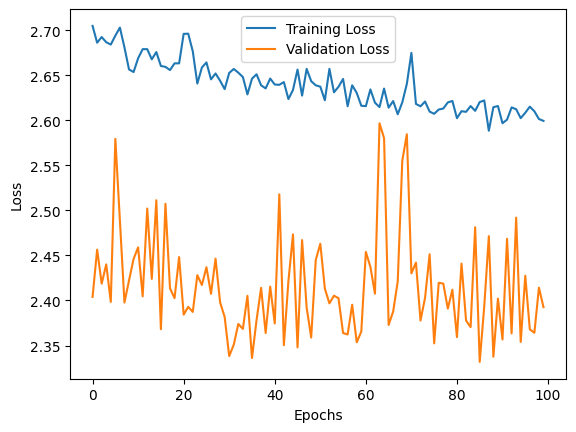

In [26]:
import matplotlib.pyplot as plt

# Vẽ đồ thị quá trình học
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [30]:
def calculate_mse(y_true, y_pred):
    n = len(y_true)
    squared_errors = [(y_true[i] - y_pred[i]) ** 2 for i in range(n)]
    mse = sum(squared_errors) / n
    return mse

# Tính MSE thủ công
mse_manual = calculate_mse(y_test, y_pred_dl)
print(f'MSE calculated manually: {mse_manual}')


MSE calculated manually: [2.9644034]


In [31]:
def calculate_accuracy(y_true, y_pred, threshold=0.1):
    n = len(y_true)
    correct_predictions = 0

    for i in range(n):
        if abs((y_true[i] - y_pred[i]) / y_true[i]) < threshold:
            correct_predictions += 1

    accuracy = (correct_predictions / n) * 100
    return accuracy

# Tính Accuracy thủ công với ngưỡng 10%
accuracy_manual = calculate_accuracy(y_test, y_pred_dl, threshold=0.1)
print(f'Accuracy calculated manually within 10%: {accuracy_manual}%')


Accuracy calculated manually within 10%: 48.06973848069738%


C:\Users\ICT\AppData\Local\Temp\ipykernel_8204\2845121104.py:6: RuntimeWarning: divide by zero encountered in divide
  if abs((y_true[i] - y_pred[i]) / y_true[i]) < threshold:
